In [33]:


import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
# !pip install missingno
import missingno as msno
from datetime import date
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)






In [34]:


def load():
    data = pd.read_csv("../../datasets/diabetes.csv")
    return data


df = load()
df.head()




,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.600,0.627,50,1
1,1,85,66,29,0,26.600,0.351,31,0
2,8,183,64,0,0,23.300,0.672,32,1
3,1,89,66,23,94,28.100,0.167,21,0
4,0,137,40,35,168,43.100,2.288,33,1


In [35]:
df.shape

(768, 9)

In [36]:
df.columns = [col.upper() for col in df.columns]

In [37]:
df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME
0,6,148,72,35,0,33.600,0.627,50,1
1,1,85,66,29,0,26.600,0.351,31,0
2,8,183,64,0,0,23.300,0.672,32,1
3,1,89,66,23,94,28.100,0.167,21,0
4,0,137,40,35,168,43.100,2.288,33,1


In [52]:
df.loc[(df['AGE']<18),'NEW_AGE_CAT'] ='young'
df.loc[(df['AGE'] >= 18) & (df['AGE'] < 56), 'NEW_AGE_CAT'] = 'mature'
df.loc[df['AGE'] >= 56, 'NEW_AGE_CAT'] = 'senior'
# BMI kategorilerini oluştur
df.loc[(df['BMI'] < 18.5), 'BMI_KATEGORI'] = 'Zayıf'
df.loc[(df['BMI'] >= 18.5) & (df['BMI'] < 25), 'BMI_KATEGORI'] = 'Sağlıklı'  # 24.9 yerine 25 kullanarak sorunu çözebilirsiniz.
df.loc[(df['BMI'] >= 25) & (df['BMI'] < 30), 'BMI_KATEGORI'] = 'Şişman'
df.loc[(df['BMI'] >= 30) & (df['BMI'] < 40), 'BMI_KATEGORI'] = 'Obez'
df.loc[df['BMI'] >= 40, 'BMI_KATEGORI'] = 'Aşırı Obez'


# Sonucu görüntüle
df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,NEW_AGE_CAT,BMI_KATEGORI
0,6.000,148.000,72,35,0.000,33.600,0.627,50.000,1,mature,Obez
1,1.000,85.000,66,29,0.000,26.600,0.351,31.000,0,mature,Şişman
2,8.000,183.000,64,0,0.000,23.300,0.672,32.000,1,mature,Sağlıklı
3,1.000,89.000,66,23,94.000,28.100,0.167,21.000,0,mature,Şişman
4,0.000,137.000,40,35,168.000,43.100,1.200,33.000,1,mature,Aşırı Obez


In [53]:

def grab_col_names(dataframe, cat_th=10, car_th=20):
    """

    Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.
    Not: Kategorik değişkenlerin içerisine numerik görünümlü kategorik değişkenler de dahildir.

    Parameters
    ------
        dataframe: dataframe
                Değişken isimleri alınmak istenilen dataframe
        cat_th: int, optional
                numerik fakat kategorik olan değişkenler için sınıf eşik değeri
        car_th: int, optinal
                kategorik fakat kardinal değişkenler için sınıf eşik değeri

    Returns
    ------
        cat_cols: list
                Kategorik değişken listesi
        num_cols: list
                Numerik değişken listesi
        cat_but_car: list
                Kategorik görünümlü kardinal değişken listesi

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = toplam değişken sayısı
        num_but_cat cat_cols'un içerisinde.
        Return olan 3 liste toplamı toplam değişken sayısına eşittir: cat_cols + num_cols + cat_but_car = değişken sayısı

    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

cat_cols, num_cols, cat_but_car = grab_col_names(df)



Observations: 768
Variables: 11
cat_cols: 3
num_cols: 8
cat_but_car: 0
num_but_cat: 1


In [54]:
cat_cols

['NEW_AGE_CAT', 'BMI_KATEGORI', 'OUTCOME']

In [55]:
df.head()


,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,NEW_AGE_CAT,BMI_KATEGORI
0,6.000,148.000,72,35,0.000,33.600,0.627,50.000,1,mature,Obez
1,1.000,85.000,66,29,0.000,26.600,0.351,31.000,0,mature,Şişman
2,8.000,183.000,64,0,0.000,23.300,0.672,32.000,1,mature,Sağlıklı
3,1.000,89.000,66,23,94.000,28.100,0.167,21.000,0,mature,Şişman
4,0.000,137.000,40,35,168.000,43.100,1.200,33.000,1,mature,Aşırı Obez


In [56]:
def outlier_thresholds(dataframe,col_name,q1 = 0.25 , q3 = 0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 +1.5 * interquantile_range
    low_limit = quartile1 -1.5 *interquantile_range
    return low_limit , up_limit
    
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)  # Değişken adı düzeltildi
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):  # Parantezler ve operatör düzeltildi
        return True
    else:
        return False

In [57]:
for col in num_cols:
    print(col,check_outlier(df,col))

PREGNANCIES False
GLUCOSE False
BLOODPRESSURE False
SKINTHICKNESS False
INSULIN False
BMI False
DIABETESPEDIGREEFUNCTION False
AGE False


In [58]:
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit


In [59]:
for col in num_cols:
    replace_with_thresholds(df,col)

In [60]:
for col in num_cols:
    print(col,check_outlier(df,col))

PREGNANCIES False
GLUCOSE False
BLOODPRESSURE False
SKINTHICKNESS False
INSULIN False
BMI False
DIABETESPEDIGREEFUNCTION False
AGE False


In [61]:
def missing_values_table ( datafreame , na_name=False):
    na_columns = [col for col in datafreame.columns if datafreame[col].isnull().sum()>0]
    n_miss = (datafreame[na_columns].isnull().sum()).sort_values(ascending = False)
    ratio = (datafreame[na_columns].isnull().sum() / datafreame.shape[0] * 100 ).sort_values(ascending =False)
    missing_df = pd.concat([n_miss , np.round(ratio,2)] , axis =1 , keys = ['n_miss' , 'ratio'])
    print(missing_df,end="\n")
    if na_columns:
        return na_columns

In [62]:
missing_values_table(df)

Empty DataFrame
Columns: [n_miss, ratio]
Index: []


In [63]:
# BMI_KATEGORI sütunundaki eksik verileri gösterme
missing_bmi_rows = df[df['BMI_KATEGORI'].isnull()]
print(missing_bmi_rows)


Empty DataFrame
Columns: [PREGNANCIES, GLUCOSE, BLOODPRESSURE, SKINTHICKNESS, INSULIN, BMI, DIABETESPEDIGREEFUNCTION, AGE, OUTCOME, NEW_AGE_CAT, BMI_KATEGORI]
Index: []


In [64]:
binary_cols = [col for col in df.columns if df[col].dtype == 'object' and df[col].nunique() == 2]
binary_cols

['NEW_AGE_CAT']

In [65]:
def label_encoder(dataframe , binary_col_name):
    label_encoder = LabelEncoder()
    dataframe[binary_col_name] = label_encoder.fit_transform(dataframe[binary_col_name])
    return dataframe
    

In [66]:
for col in binary_cols:
    df = label_encoder(df,col)

In [67]:
import pandas as pd

def rare_analyser(dataframe, target, cat_cols):
    for col in cat_cols:
        print(col, ":", len(dataframe[col].value_counts()))
        print(pd.DataFrame({"COUNT": dataframe[col].value_counts(),
                            "RATIO": dataframe[col].value_counts() / len(dataframe),
                            "TARGET_MEAN": dataframe.groupby(col)[target].mean()}), end="\n\n\n")

In [68]:

def rare_encoder(dataframe, rare_perc):
    temp_df = dataframe.copy()

    rare_columns = [col for col in temp_df.columns if temp_df[col].dtypes == 'O'
                    and (temp_df[col].value_counts() / len(temp_df) < rare_perc).any(axis=None)]

    for var in rare_columns:
        tmp = temp_df[var].value_counts() / len(temp_df)
        rare_labels = tmp[tmp < rare_perc].index
        temp_df[var] = np.where(temp_df[var].isin(rare_labels), 'Rare', temp_df[var])

    return temp_df

In [69]:
rare_cols = rare_analyser(df, "OUTCOME",cat_cols)

NEW_AGE_CAT : 2
             COUNT  RATIO  TARGET_MEAN
NEW_AGE_CAT                           
0              718  0.935        0.350
1               50  0.065        0.340


BMI_KATEGORI : 5
              COUNT  RATIO  TARGET_MEAN
BMI_KATEGORI                           
Aşırı Obez       98  0.128        0.561
Obez            374  0.487        0.439
Sağlıklı        102  0.133        0.069
Zayıf            15  0.020        0.133
Şişman          179  0.233        0.223


OUTCOME : 2
         COUNT  RATIO  TARGET_MEAN
OUTCOME                           
0          500  0.651        0.000
1          268  0.349        1.000




In [71]:
ohe_cols = [col for col in df.columns if 10 >= df[col].nunique()>2]
ohe_cols

['BMI_KATEGORI']

In [72]:
def one_hot_encoder(dataframe, categorical_cols , drop_first=True):
    dataframe = pd.get_dummies(dataframe , columns=categorical_cols , drop_first=drop_first)
    return dataframe

In [73]:
df=one_hot_encoder(df,ohe_cols)

In [74]:
df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,NEW_AGE_CAT,BMI_KATEGORI_Obez,BMI_KATEGORI_Sağlıklı,BMI_KATEGORI_Zayıf,BMI_KATEGORI_Şişman
0,6.000,148.000,72,35,0.000,33.600,0.627,50.000,1,0,True,False,False,False
1,1.000,85.000,66,29,0.000,26.600,0.351,31.000,0,0,False,False,False,True
2,8.000,183.000,64,0,0.000,23.300,0.672,32.000,1,0,False,True,False,False
3,1.000,89.000,66,23,94.000,28.100,0.167,21.000,0,0,False,False,False,True
4,0.000,137.000,40,35,168.000,43.100,1.200,33.000,1,0,False,False,False,False


In [75]:
df.shape

(768, 14)

In [76]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)


Observations: 768
Variables: 14
cat_cols: 6
num_cols: 8
cat_but_car: 0
num_but_cat: 6


In [77]:
num_cols

['PREGNANCIES',
 'GLUCOSE',
 'BLOODPRESSURE',
 'SKINTHICKNESS',
 'INSULIN',
 'BMI',
 'DIABETESPEDIGREEFUNCTION',
 'AGE']

In [78]:
rare_cols = rare_analyser(df, "OUTCOME",cat_cols)

OUTCOME : 2
         COUNT  RATIO  TARGET_MEAN
OUTCOME                           
0          500  0.651        0.000
1          268  0.349        1.000


NEW_AGE_CAT : 2
             COUNT  RATIO  TARGET_MEAN
NEW_AGE_CAT                           
0              718  0.935        0.350
1               50  0.065        0.340


BMI_KATEGORI_Obez : 2
                   COUNT  RATIO  TARGET_MEAN
BMI_KATEGORI_Obez                           
False                394  0.513        0.264
True                 374  0.487        0.439


BMI_KATEGORI_Sağlıklı : 2
                       COUNT  RATIO  TARGET_MEAN
BMI_KATEGORI_Sağlıklı                           
False                    666  0.867        0.392
True                     102  0.133        0.069


BMI_KATEGORI_Zayıf : 2
                    COUNT  RATIO  TARGET_MEAN
BMI_KATEGORI_Zayıf                           
False                 753  0.980        0.353
True                   15  0.020        0.133


BMI_KATEGORI_Şişman : 2
           

In [79]:
useless_cols = [col for col in df.columns if df[col].nunique() == 2 and 
                (df[col].value_counts() / len(df) < 0.01).any(axis=None)]

In [80]:
useless_cols

[]

In [81]:
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])
df[num_cols].head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE
0,0.647,0.862,0.093,0.915,-0.788,0.209,0.589,1.446
1,-0.849,-1.159,-0.330,0.536,-0.788,-0.784,-0.378,-0.189
2,1.246,1.985,-0.471,-1.295,-0.788,-1.253,0.747,-0.103
3,-0.849,-1.031,-0.330,0.157,0.218,-0.571,-1.023,-1.050
4,-1.148,0.509,-2.163,0.915,1.009,1.558,2.597,-0.017


In [83]:
y = df["OUTCOME"]

X = df.drop(["OUTCOME"],axis=1)

In [86]:
X_train , X_test , y_train , y_test = train_test_split(X,y,test_size=0.30 ,random_state=17)


In [87]:
from sklearn.ensemble import RandomForestClassifier

In [88]:
rf_model = RandomForestClassifier(random_state=46).fit(X_train,y_train)

y_pred = rf_model.predict(X_test)

accuracy_score(y_pred,y_test)

0.7792207792207793

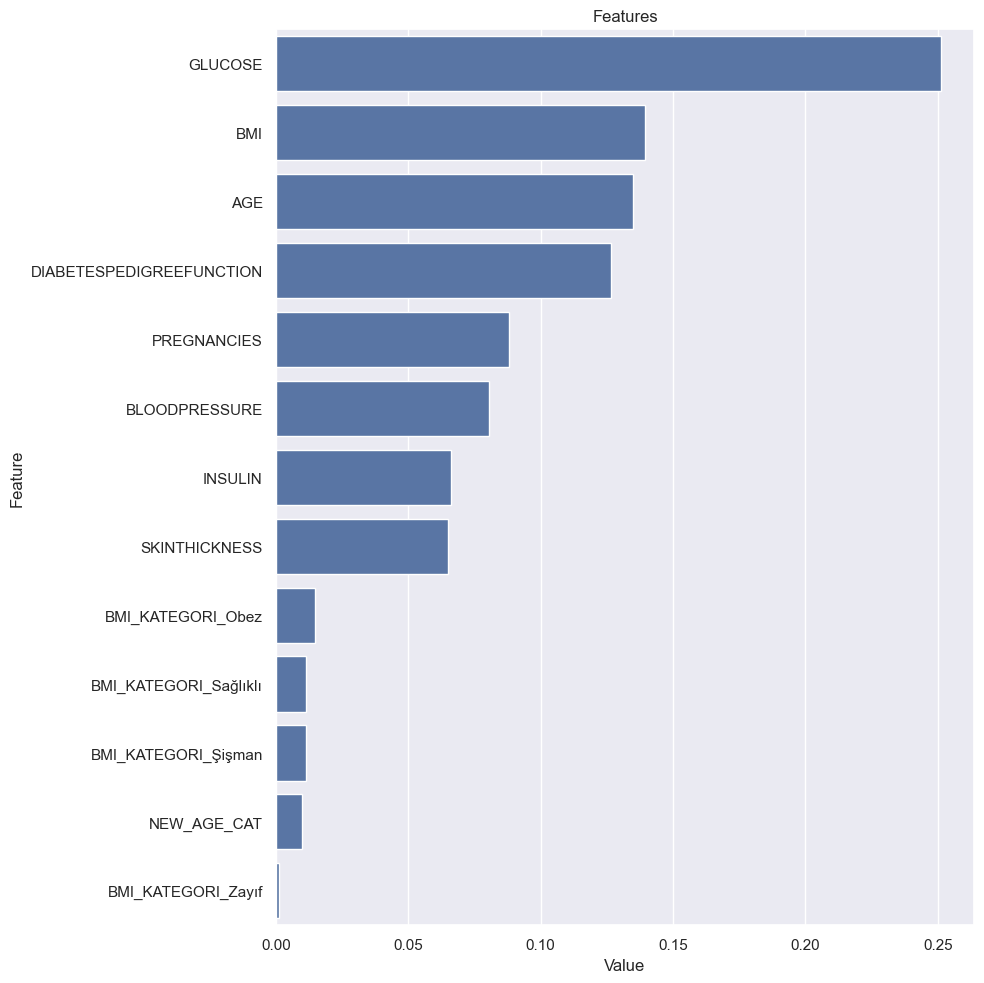

In [89]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                      ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')


plot_importance(rf_model, X_train)

In [90]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score

# Veri setinizi X ve y olarak ayırın
# Örneğin:
# X = df.drop('target_column', axis=1)
# y = df['target_column']

# Veri setini eğitim ve test olarak ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=17)

# Random Forest için hiper parametre grid'i oluşturma
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# GridSearchCV ile hiper parametre optimizasyonu
rf_model = RandomForestClassifier(random_state=46)
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid,
                           cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# En iyi hiper parametreleri ve en iyi doğruluk skorunu yazdırma
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# En iyi modeli kullanarak tahmin yapma
best_rf_model = grid_search.best_estimator_
y_pred = best_rf_model.predict(X_test)

# Test setindeki doğruluk skorunu hesaplama
accuracy = accuracy_score(y_pred, y_test)
print("Test Accuracy:", accuracy)


Fitting 3 folds for each of 648 candidates, totalling 1944 fits


C:\Users\hasan\AppData\Roaming\Python\Python312\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
321 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\hasan\AppData\Roaming\Python\Python312\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\hasan\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "C:\Users\hasan\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py", line 666, in _validate_params
    val

Best Parameters: {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Best Score: 0.7914338919925513
Test Accuracy: 0.7878787878787878
